Based on "https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py"

In [1]:
import random

import argparse

from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import json

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Environment

In [2]:
env = gym.make('MsPacman-v0')
obsertation = env.reset()
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
nb_actions

9

In [3]:
state = env.reset()
state.shape

(210, 160, 3)

In [4]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

In [5]:
class AtariProcessor(Processor):
      
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [6]:
def visualize_log(filename, figsize=None, output=None):
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'episode' not in data:
        raise ValueError('Log file "{}" does not contain the "episode" key.'.format(filename))
    episodes = data['episode']

    # Get value keys. The x axis is shared and is the number of episodes.
    keys = sorted(list(set(data.keys()).difference(set(['episode']))))

    if figsize is None:
        figsize = (15., 5. * len(keys))
    f, axarr = plt.subplots(len(keys), sharex=True, figsize=figsize)
    for idx, key in enumerate(keys):
        axarr[idx].plot(episodes, data[key])
        axarr[idx].set_ylabel(key)
    plt.xlabel('episodes')
    plt.tight_layout()
    if output is None:
        plt.show()
    else:
        plt.savefig(output)

## Model

### Hyperparameters

In [7]:
K.image_dim_ordering()

'tf'

### Deep Q-learning model

In [8]:
# The model that was described by Mnih et al. (2015).

model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4),activation='relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2),activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1),activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 4617      
Total para

In [9]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=10000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

In [10]:
# eps-greedy action selection: a random action is selected with probability eps. 
# We anneal eps from 1.0 to 0.1 over the course of 1000 steps. This is done so that
# the agent initially explores the environment (high eps) and then gradually sticks to what it knows
# (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
# so that the agent still performs some random actions. This ensures that the agent cannot get stuck.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000)

In [11]:
#policy = BoltzmannQPolicy(tau=1.)
# Muy mal... rewards son iguales como 7.

In [12]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])

Training for 1750 steps ...
Interval 1 (0 steps performed)
 1750/10000 [====>.........................] - ETA: 1:45 - reward: 0.0566done, took 22.372 seconds
Testing for 10 episodes ...
Episode 1: reward: 32.000, steps: 846
Episode 2: reward: 42.000, steps: 930
Episode 3: reward: 35.000, steps: 878
Episode 4: reward: 37.000, steps: 791
Episode 5: reward: 31.000, steps: 880
Episode 6: reward: 35.000, steps: 809
Episode 7: reward: 24.000, steps: 725
Episode 8: reward: 34.000, steps: 852
Episode 9: reward: 37.000, steps: 776
Episode 10: reward: 20.000, steps: 500


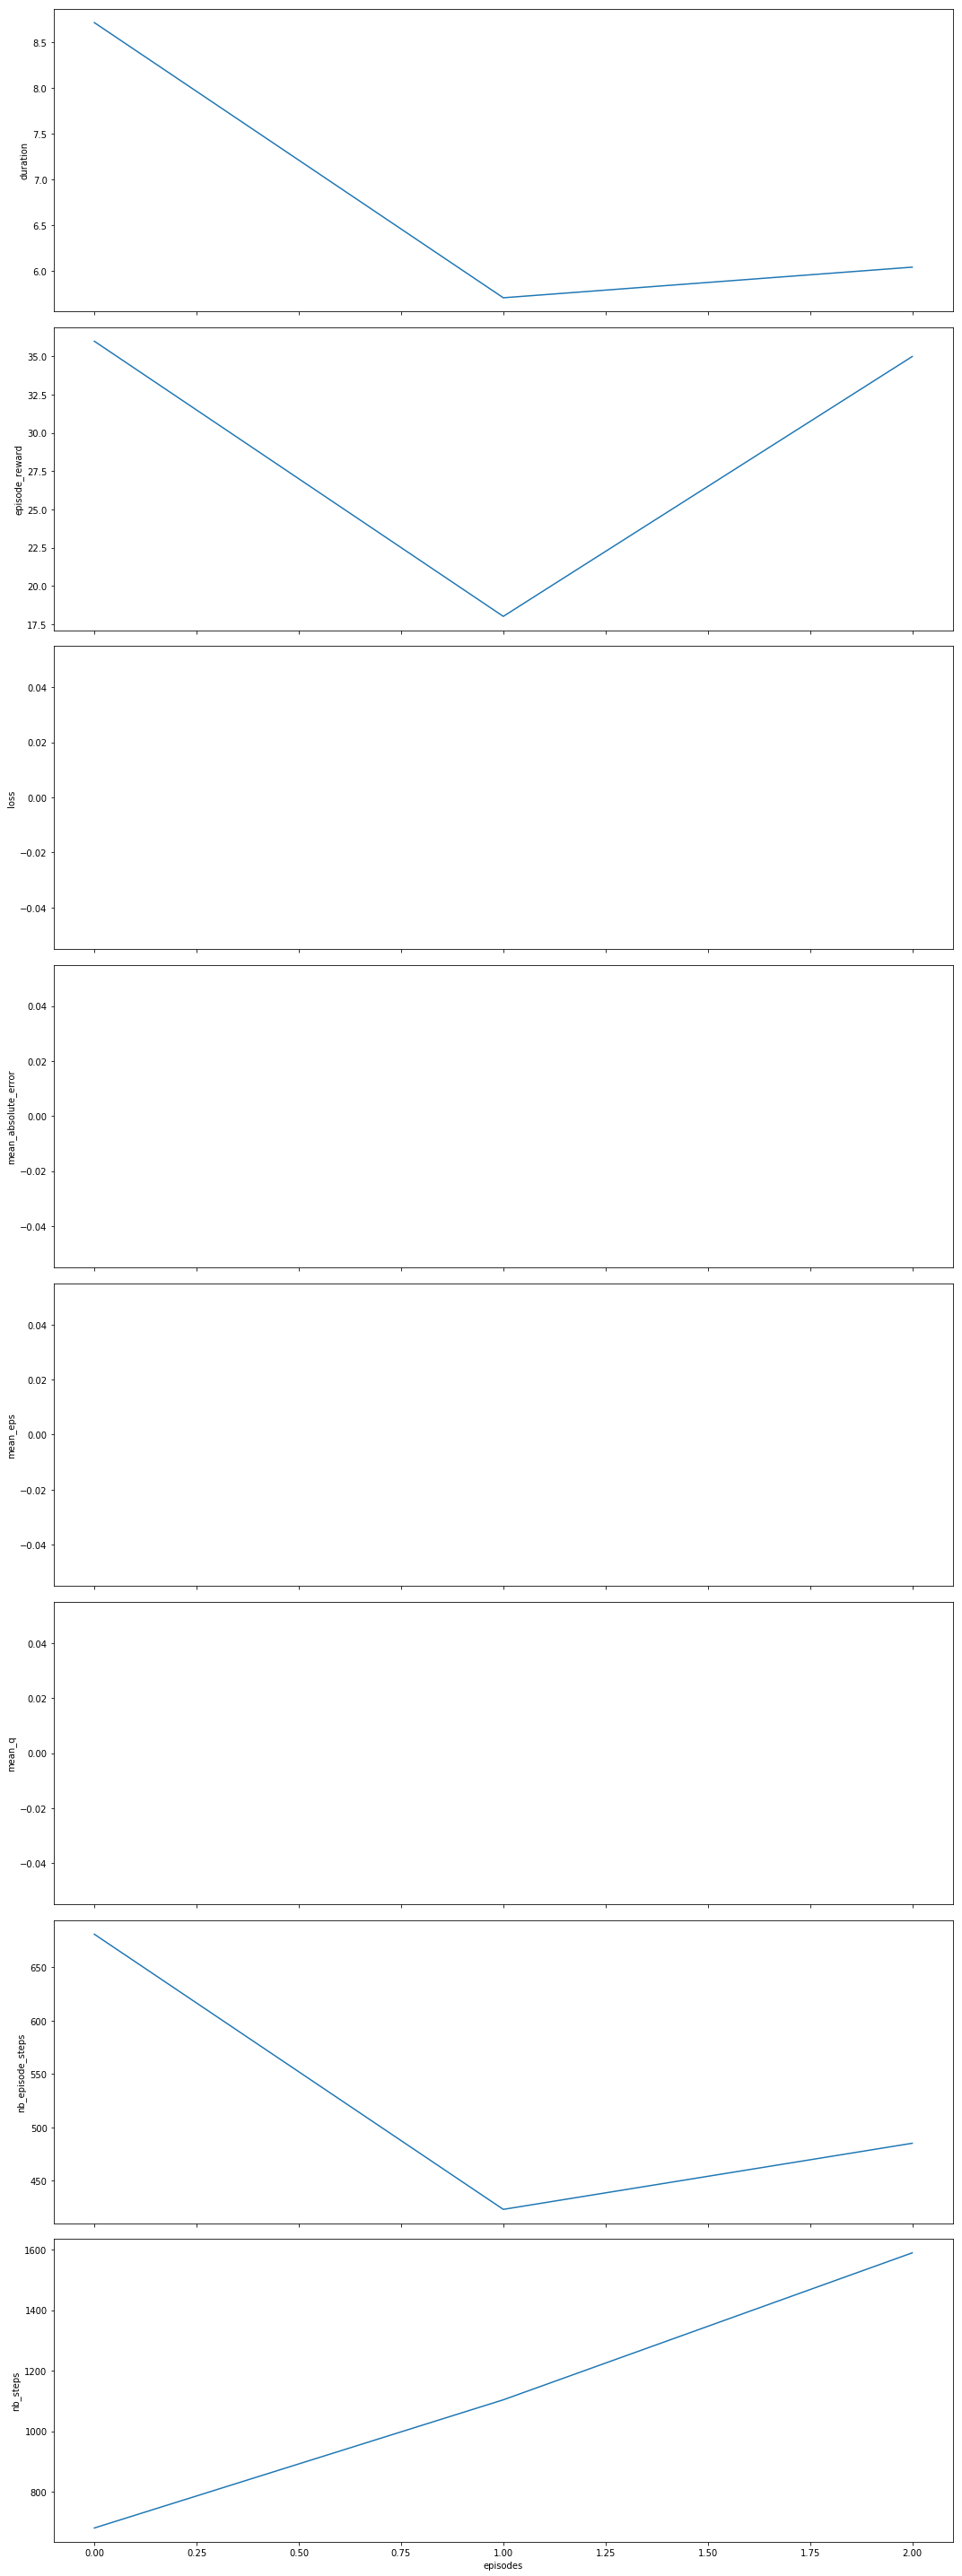

In [14]:
# Okay, now it's time to learn something! We capture the interrupt exception so that training
# can be prematurely aborted. Notice that you can the built-in Keras callbacks!
env_name = 'MsPacman-v0'

weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)

callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=2500)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=1750, log_interval=10000)

# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

# Finally, evaluate our algorithm for 10 episodes.
dqn.test(env, nb_episodes=10, visualize=False)
visualize_log(log_filename, output='model.png', figsize=None)


In [15]:
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)

dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 31.000, steps: 1052
Episode 2: reward: 27.000, steps: 799
Episode 3: reward: 33.000, steps: 529
Episode 4: reward: 20.000, steps: 504
Episode 5: reward: 47.000, steps: 899
Episode 6: reward: 22.000, steps: 1099
Episode 7: reward: 46.000, steps: 803
Episode 8: reward: 41.000, steps: 898
Episode 9: reward: 31.000, steps: 722
Episode 10: reward: 20.000, steps: 504
